In [1]:
%matplotlib inline
from batman import TransitModel
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.coordinates import get_body
from astropy.constants import R_sun
from batman import TransitParams

In [2]:
from astropy.time import Time
from astropy.coordinates import HeliocentricTrueEcliptic

https://nssdc.gsfc.nasa.gov/planetary/factsheet/

http://www.met.rdg.ac.uk/~ross/Astronomy/Planets.html

https://www.princeton.edu/~willman/planetary_systems/Sol/

In [3]:
observer_inclination = -0.1

u_ld = [0.24, 0.36]

mercury = TransitParams()
mercury.per = 0.3870993 * 365.25
mercury.a = float(0.3870993*u.AU/R_sun)
mercury.rp = float(4879/2*u.km/R_sun)
mercury.inc = 90 + observer_inclination
mercury.ecc = 0.205
mercury.w = 77.45645
mercury.limb_dark = 'quadratic'
mercury.u = u_ld

venus = TransitParams()
venus.per = 0.61519726 * 365.25
venus.a = float(0.723336*u.AU/R_sun)
venus.rp = float(12104/2*u.km/R_sun)
venus.inc = 90 + observer_inclination
venus.ecc = 0.00678
venus.w = 131.53298
venus.limb_dark = 'quadratic'
venus.u = u_ld

earth = TransitParams()
earth.per = 365.25
earth.a = float(1.000003*u.AU/R_sun)
earth.rp = float(12756/2*u.km/R_sun)
earth.inc = 90 + observer_inclination
earth.ecc = 0.01671
earth.w = 102.94719
earth.limb_dark = 'quadratic'
earth.u = u_ld

ref_time = Time('2000-01-01')
mercury_coord = get_body('mercury', ref_time).transform_to(HeliocentricTrueEcliptic)
venus_coord = get_body('venus', ref_time).transform_to(HeliocentricTrueEcliptic)
earth_coord = get_body('earth', ref_time).transform_to(HeliocentricTrueEcliptic)

mercury.t0 = float((earth_coord.lon - mercury_coord.lon) / (2*np.pi * u.rad)) * mercury.per
venus.t0 = float((earth_coord.lon - venus_coord.lon) / (2*np.pi * u.rad)) * venus.per
earth.t0 = float((earth_coord.lon - earth_coord.lon) / (2*np.pi * u.rad)) * earth.per

In [4]:
mercury.t0

-59.90176218199254

In [5]:
from fleck import Star, generate_spots

In [39]:
times = np.linspace(0, 4*365.25, 100000)
n_spots = 10

lons, lats, rads, inc_stellar = generate_spots(min_latitude=-5, max_latitude=-30, 
                                               spot_radius=0.03, n_spots=n_spots, 
                                               inclinations=np.array([90])*u.deg)

In [40]:
import sys
sys.path.insert(0, '/Users/bmmorris/git/shocksgo')
from shocksgo import generate_solar_fluxes

In [41]:
sun = Star(spot_contrast=0.7, u_ld=u_ld, rotation_period=26.2)

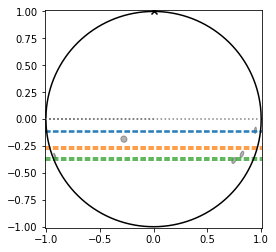

In [42]:
sun.plot(lons, lats, rads, inc_stellar, time=0, time_ref=0, planet=[mercury, venus, earth])

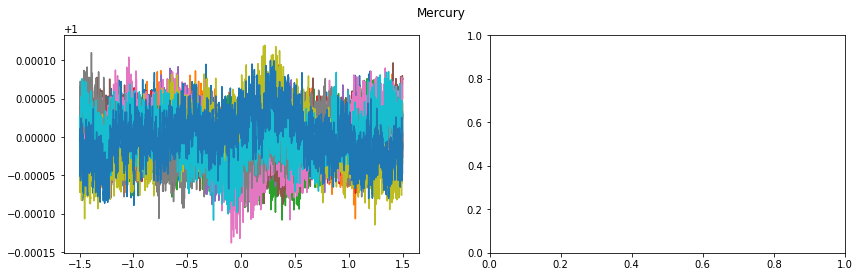

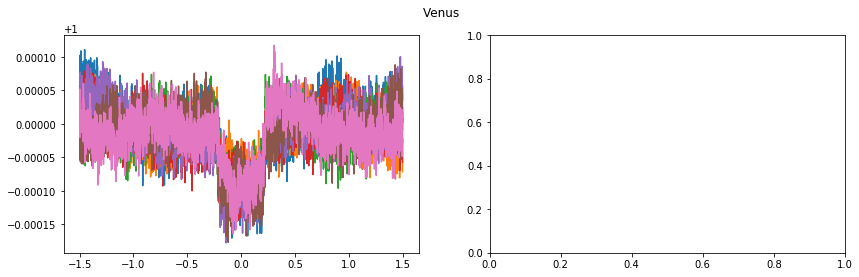

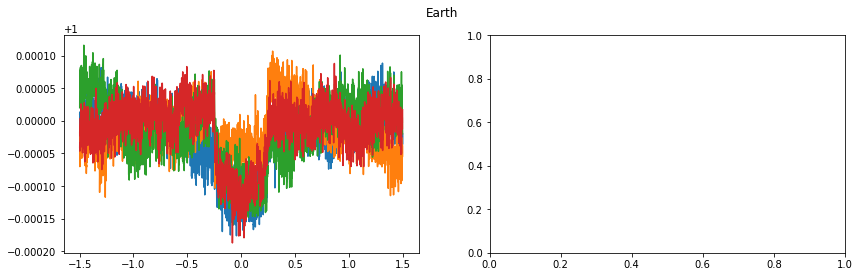

In [59]:
min_time = -100
max_time = min_time + 4*365.25
window = 1.5
duration = 1

for params, name in zip([mercury, venus, earth], 'Mercury Venus Earth'.split()):
    next_100_transits = np.arange(100)*params.per + params.t0
    midtransit_times = next_100_transits[next_100_transits < max_time]

    fig, ax = plt.subplots(1, 2, figsize=(14, 4))
    fig.suptitle(name)
    for midtransit_time in midtransit_times: 
        t = np.arange(midtransit_time-window, midtransit_time+window, 45/60/60/24)
        oot = (t < midtransit_time - duration) | (t > midtransit_time + duration)
        
        transit = sun.light_curve(lons, lats, rads, inc_stellar[0], times=t, planet=params, time_ref=0, fast=True)[:, 0]
        
        noise_t, noise_f, noise_kernel = generate_solar_fluxes((len(t) * 45/60/60/24)*u.day, cadence=45*u.s)
        
        fit = np.polyval(np.polyfit(t[oot] - t.mean(), transit[oot], 3), t-t.mean())
        
        ax[0].plot(t - t.mean(), transit/fit + noise_f)
    plt.show()